# Dokumentace k projektu z ISS, FIT VUT 2021/22
#### Autor: Hung Do
#### Datum: 07.01.2022
#### Login: xdohun00

## První úkol
Následující příkazy slouží k načtení wav souboru a vypsání dodatečných informací. To je docíleno pomocí příkazu `scipy.io.wavfile.read()`, který vrací pole hodnot a vzorkovací frekvenci. Délka nahrávky se vypočítá jako podíl počtu vzorků a vzorkovací frekvence.

In [491]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

Pocet vzorku: 71066
Delka signalu: 4.441625
Max: 2363
Min: -2316


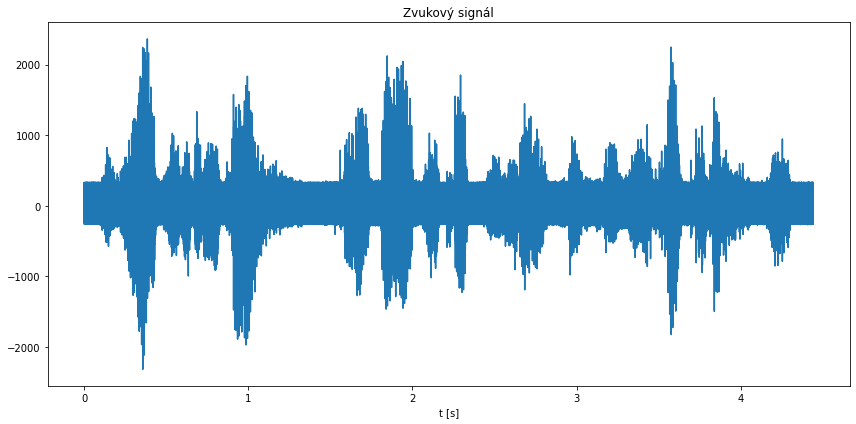

In [492]:
# cesta k souboru
FILE_PATH = '../audio/xdohun00.wav'
fs, data = wavfile.read(FILE_PATH)

# pocet sekund
time_len = data.size / fs

# hodnota pro zapis wavfile souboru
data_max = data.max()

# vypis informaci
print(f"Pocet vzorku: {data.size}")
print(f"Delka signalu: {time_len}")
print(f"Max: {data.max()}")
print(f"Min: {data.min()}")

# vykresleni grafu
time = np.arange(data.size) / fs
plt.figure(figsize=(12, 6))
plt.plot(time, data)

# pojemnovani os
plt.gca().set_xlabel('t [s]')
plt.gca().set_title('Zvukový signál')
plt.tight_layout()

## Druhý úkol
Ve druhém úkolu se ustředňuje signál, normuje se a rozděluje se do rámců. Střední hodnota se vypočítá jako aritmetický průměr jednotlivých hodnot. Jednotlivé rámce se vytváří pomocí jednoduchého cyklu, během kterého se vymezí jednotlivé rámce (frames) do pole a vkládají se do seznmau rámců.

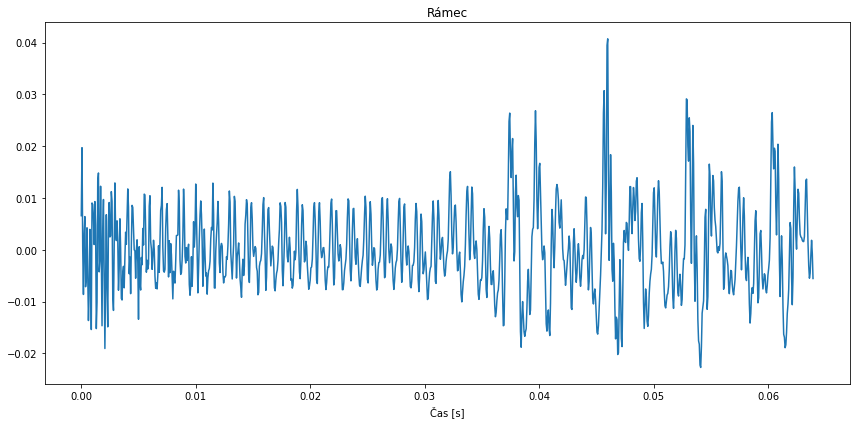

In [493]:
# ustredneni signalu
mean = sum(data) / data.size
data = data - mean

# normalizace
data = data / 2**15

# tvorba ramcu
lof_frames = []
i = 0
while True:
    # posledni ramec doplni nulami
    if i + 1024 > data.size:
        last_frame = data[i:data.size-1] + np.zeros(data.size-i-1)
        lof_frames.append(np.array(last_frame))
        break
    lof_frames.append(np.array(data[i:i+1024]))
    i += 512

# vybrany ramec 
frame = lof_frames[20]

# vykresleni grafu
plt.figure(figsize=(12, 6))
plt.plot(np.arange(1024) / fs, lof_frames[20])
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_title('Rámec')
plt.tight_layout()

## Třetí úkol
Třetí úloha spočívá v pouažítí DFT (diskrétní Fourierova transformace). Nejprve se pomocí příkazu `scipy.linalg.dft` vytvoří matice o velikosti 1024x1024, který se poté vynásobí s vektorem rámce. Výsledné hodnoty se hodí do absolutní hodnoty.

Výstup vytvořené funkce je shodná s věstavenou funkcí fft.


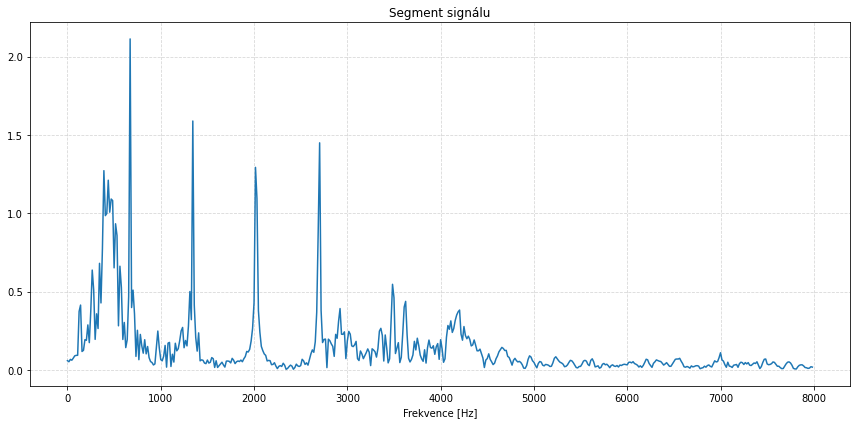

In [494]:
from scipy.linalg import dft

N = len(frame)

# vypocet pomoci matice a ulozeni pole do promenne
matrix = dft(N)
spect = abs(matrix @ frame)

# vypocet dft pomoci iterace
# for k in range(N):
#     base = np.exp([-2j * np.pi / N * k * n
#                    for n in range(N)])
#     spect.append(abs(np.matmul(frame, base)))

# kontrola s fft
ft = np.fft.fft(frame)
print("Výstup vytvořené funkce {} shodná s věstavenou funkcí fft.".format(
      "je" if np.allclose(abs(ft), spect) else "není"))

# vykresleni grafu od 0 do fs/2
plt.figure(figsize=(12, 6))
plt.plot(np.arange(N/2) * fs / N, spect[0:len(spect)//2])

# pojmenovani os
plt.gca().set_xlabel('Frekvence [Hz]')
plt.gca().set_title('Segment signálu')
plt.gca().grid(alpha=0.5, linestyle='--')
plt.tight_layout()

## Spektrogram
Kostrou tohoto úkolu je příkaz `scipy.signal.spectrogram`, který vrací všechny důležitá data k zobrazení spektrogramu signálu.

In [495]:
from scipy.signal import spectrogram

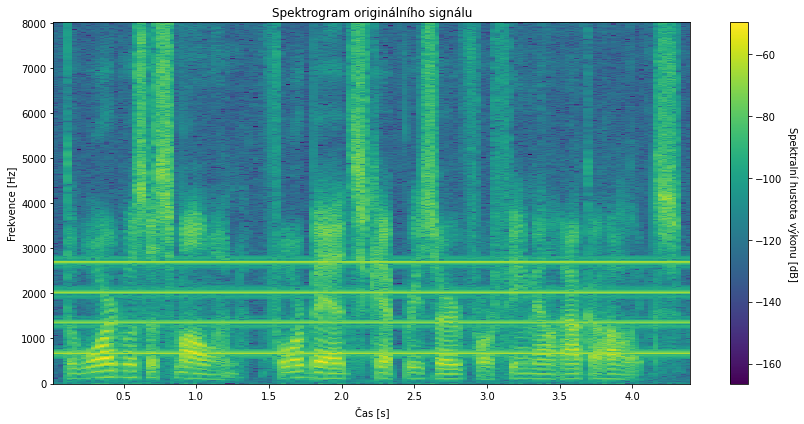

In [496]:
# spektrogram za pouziti ramcu o 1024 vzorcich s presahy 512
f, t, sgr = spectrogram(data, fs, nperseg=1024, noverlap=512)

# uprava jednotlivych koeficientu DFT na logaritmickou stupnici
sgr_log = 10 * np.log10(sgr+1e-20)

# vykresleni grafu
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, sgr_log)

# pojemnovani os
plt.gca().set_title('Spektrogram originálního signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

## Určení rušivých signálů
Frekvence rušivých signálů můžeme určit z grafu `Segment signálu`, nebo ze spektrogramu. Já to určil pomocí knihovní funkce `scipy.signal.find_peaks`, který hledá ostré hrany a vrací indexy hodnot v seznamu, kde se hrany nachází.

In [497]:
from scipy.signal import find_peaks

In [498]:
# seznam jednotlivych frekvenci rusivych signalu
cos_freq = []

# seznam indexu rusivych frekvenci v ramci
# pouziti v dalsich ukolu
cos_indices = []
spect = abs(matrix @ lof_frames[0])

# indexy rusivych frekvenci v signalu
# hleda ostré hrany v segmentech po 10
peaks, _ = find_peaks(spect[0:len(spect)//2], distance=10)

# ulozeni hodnot s hodnotami ostrych hran vetsich nez 1
cos_indices = list(filter(lambda x: spect[x] > 1., peaks)) 

# ulozeni nalezenych frekvenci
# cos_freq = [(i+1) * 671.875 for i in range(4)]
cos_freq = [i * fs / 1024 for i in cos_indices]

# presny vypis rusivych frekvenci
print(f"Rušivé frekvence v Hz: {cos_freq}")

Rušivé frekvence v Hz: [671.875, 1343.75, 2015.625, 2703.125]


## Generování signálu
Nyní vygenerujeme signál, který nám rušil původní signál. Sečteme 4 kosíny o frekvencích uložených v `cos_freq` a zapíšeme do souboru `4cos.wav`.

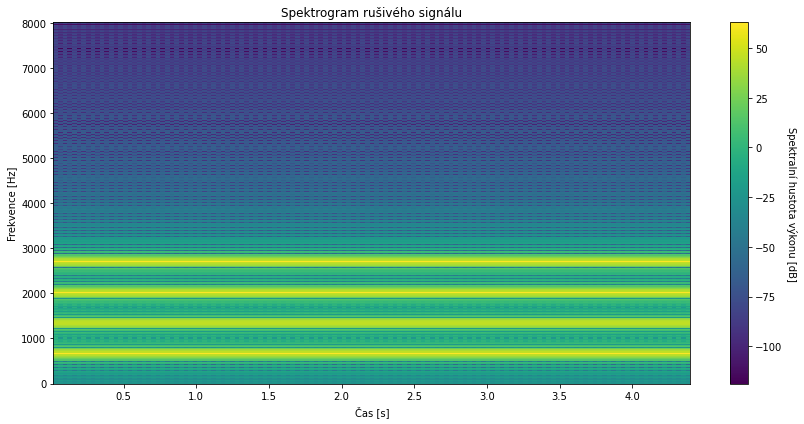

In [499]:
# hlasitost
volume = 1

# vytvoreni pole hodnot x-sove osy
nof_samples = np.arange(data.size) / fs

# vytvoreni souctu 4 kosin
output_cos = sum([volume * np.cos(2 * np.pi * f * nof_samples)
                  for f in cos_freq])

# normalizace signalu a nasobenim int16_max pro 16bit
output_cos = output_cos / max(abs(output_cos))
output_cos = np.iinfo(np.int16).max * output_cos

# output_cos = np.iinfo(np.int16).max * output_cos
# vygenerovani spektrogramu
f, t, sgr = spectrogram(output_cos, fs, nperseg=1024, noverlap=512)

# uprava jednotlivych koeficientu DFT na logaritmickou stupnici
sgr_log = 10 * np.log10(sgr+1e-20)

# vykresleni grafu
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, sgr_log)

# pojemnovani os
plt.gca().set_title('Spektrogram rušivého signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

plt.tight_layout()

# generovani souboru
wavfile.write(get_audio_path('4cos.wav'), fs, output_cos.astype(np.int16))

## Čisticí filtr
V zadání jsou 3 možnosti, jak vytvořit filtry:
- výrova filtru v z-rovině
- návrh filtru ze spektra
- návrh 4 pásmových zádrží

Zkusil jsem vytvořit všechny 3 filtry. Někde jsem byl úspěšnější, někde méně.

### Výroba filtru v z rovině

Nejprve jsem si vypočítal nulové body sedící na jednotkové kružnici v komplexní rovině. Toho docílíme dosazením do vzorce. 

$$ \large
    n_k = e^{j \omega_k}\\
    \large
    n_k = e^{j 2 \pi \frac{f_k}{Fs}}
$$

Poté přidáme jejich komplexně sdružené hodnoty a převedeme na koeficienty. Implusní odezvu vypočítáme pomocí konvoluce jednotkového impulsu a našeho filtru.

In [500]:
from scipy.signal import lfilter

b: [  1.          -6.0393444   17.41683059 -31.07480027  37.40610065
 -31.07480027  17.41683059  -6.0393444    1.        ]
a: [1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


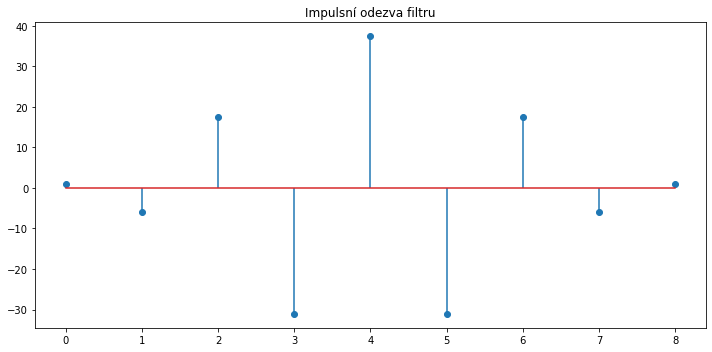

In [501]:
# vypocet jednotlivych omega_k ze vzorce 2 * pi * f_k / Fs
omega_k = list(map(lambda f: 2 * np.pi * f / fs, cos_freq))

# vypocet n_k ze vzorce n_k = e^(j*omega_k)
n_k = [np.exp(1j * omega) for omega in omega_k]

# pridani komplexne sdruzenych nulovych bodu a hledani
# koeficientu filtru
n_k = n_k + [np.conj(n) for n in n_k]
b, a = np.poly(n_k), [1, *np.zeros(len(n_k))]

# jednotkovy impuls a impulsni odezva
nof_imp = 9
imp = [1, *np.zeros(nof_imp-1)]
h = lfilter(b, a, imp)

# vypis keoficientu
print(f'b: {b}')
print(f'a: {a}')

plt.figure(figsize=(10, 5))
plt.stem(np.arange(len(h)), h)
plt.gca().set_title('Impulsní odezva filtru')

plt.tight_layout()

<a id='zeros_and_poles'></a>
### Nuly a póly
Nuly a póly vypočítáme pomocí příkazu `scipy.signal.ft2zpk` a body zobrazíme na jednotkové kružnici.

In [502]:
from scipy.signal import tf2zpk

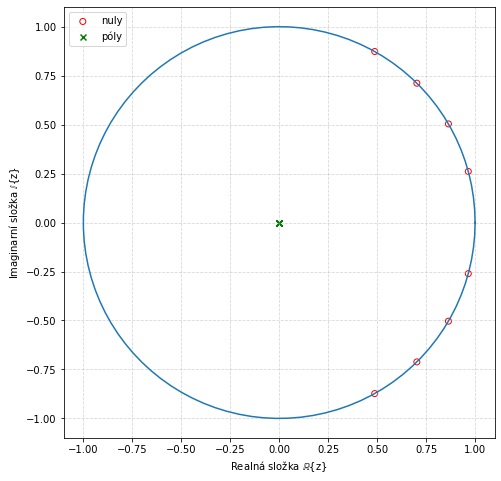

In [503]:
# zjisteni nul a polu
# tez mozno pouzit z = np.roots(b)
z, p, _ = tf2zpk(b, a)

plt.figure(figsize=(7, 7))
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none',
            edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g',
            label='póly')

# pojmenovani os
plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
plt.gca().set_aspect('equal')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

<a id='frequency_response'></a>
### Frekvenční charakteristika
Frekvenční charakteristiku vygenerujeme pomocí příkazu `scipy.signal.freqz`. Ten  nám vygeneruje magnitudu a argument $ H(e^{j \omega}) $.

In [504]:
from scipy.signal import freqz

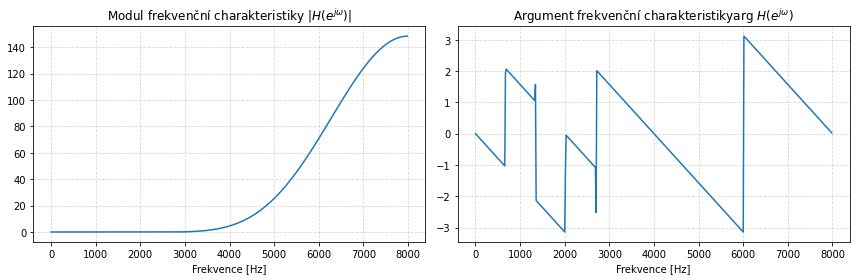

In [505]:
# frekvencni charakteristika
w, H = freqz(b, a)

# vykresleni grafu
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(w / 2 / np.pi * fs, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * fs, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky' \
                '$\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

<a id='filtration'></a>
### Filtrace
Nyní již máme všechno k tomu, abychom dokázali originální signál vyfiltrovat. Použijeme na to příkaz `scipy.signal.lfilter`, který provede konvoluci impulsní odezvy na originální signál. Nasledně provedu normalizaci vyfiltrovaného signálu pomocí dělením maximem signálu v absolutní hodnotě a vynásobením int16_max hodnotou pro zesílení zvuku. Zvuk -1 až 1 totiž nejde ve formátu int16 slyšet.

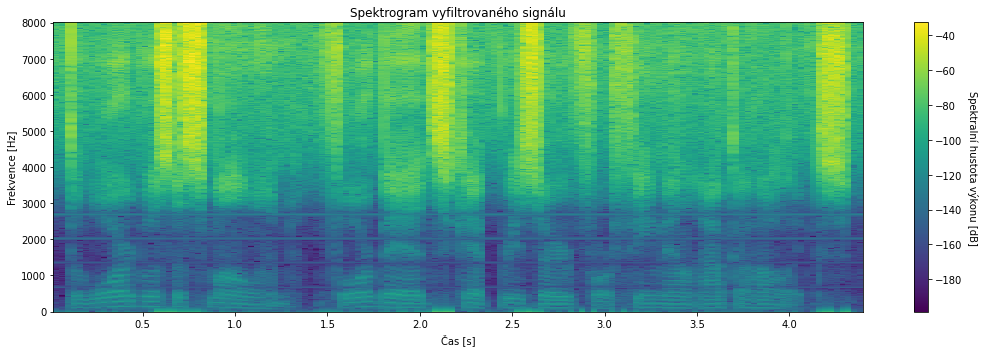

In [506]:
# provedeni filtrace
filtered_z = lfilter(b, a, data)

# vykresleni spektrogramu
f, t, sfgr = spectrogram(filtered_z, fs, nperseg=1024, noverlap=512)
sfgr_log = 10 * np.log10(sfgr+1e-20)

plt.figure(figsize=(15, 5))
plt.pcolormesh(t, f, sfgr_log)

# pojemovani os
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

# normalizace signalu
filtered_max = filtered_z.max()
filtered_z = filtered_z / filtered_max

# zvetseni hlasitosti
filtered_z = np.iinfo(np.int16).max * filtered_z

plt.tight_layout()

# vytvoreni vyfiltrovaneho souboru
wavfile.write(get_audio_path(f'clean_z.wav'), fs, filtered_z.astype(np.int16))

### Výsledek filtrace
Ze spektrogramu vyfiltrovaného signálu můžeme pozorovat, že rušivé frekvence se nám podařili odstranit. Problémem je, že filtrace velice zkreslila původní signál. V porovnání s originálním signálem filtr "zeslabil" frekvence pod $3$ kHz (tmavá barva) a "zesílil" frekvence nad $3$ kHz (světlá barva). 

Vysvětlení najdeme v modulu frekvenční charakteristiky. Z grafu frekvenční charakteristiky můžeme vyčíst, že se jedná o horní propust. To znamená, že nízké frekvence jsou utlumovány (do $\pm 3.2$ kHz). Body nad $3.2$ kHz nabývají hodnotami nad 1, což znamená, že původní signál zesiluje. 

### Návrh filtru ze spektra
Nyní zkusíme vytvořit druhý filtr a to ze spektra. Nejprve si vygenerujeme frekvenční charakteristiku našeho filtru, který v rozmezí 1024 vzorků bude obsahovat všude hodnotu 1. Na indexech frekvencí rušivého signálu nastavíme hodnoty na 0. Můžeme buďto použít náš seznam `cos_indices`, nebo indexy spočítat matematicky:

$$ \large
index_k = \left \lfloor 1024 \cdot \frac{f_k}{Fs} \right \rfloor
$$

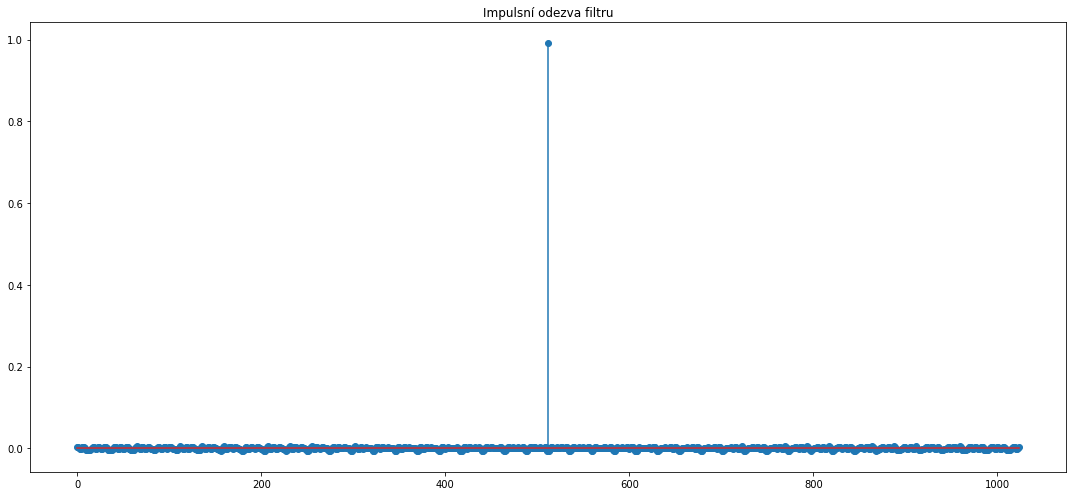

In [507]:
# vypln frekvencni charakteristiky jednickami krome 
# indexu s rusivymi frekvencemi
H = list(np.ones(513))
for i in cos_indices:
    H[i] = 0

# pripojeni druhe poloviny frekvencni charakteristiky
H = H + list(np.flip(H[1:512], 0))

# provedena inverzni FFT a posun prvniho indedu doprostred
# navrat jen realne casti
ret_val = np.real(np.fft.fftshift(np.fft.ifft(H)))
b, a = ret_val, [1, *np.zeros(len(ret_val)-1)]

# generovani jednotkoveho impulsu
# a zobrazeni impulsni odezvy
nof_imp = 1024
imp = [1, *np.zeros(nof_imp-1)]
h = lfilter(b, a, imp)

plt.figure(figsize=(15, 7))
plt.stem(np.arange(len(h)), h)
plt.gca().set_title('Impulsní odezva filtru')

plt.tight_layout()

### Nuly a póly
Stejně jako u [výroby filtru v z-rovině](#zeros_and_poles), proces výpočtu je tu zde stejný.

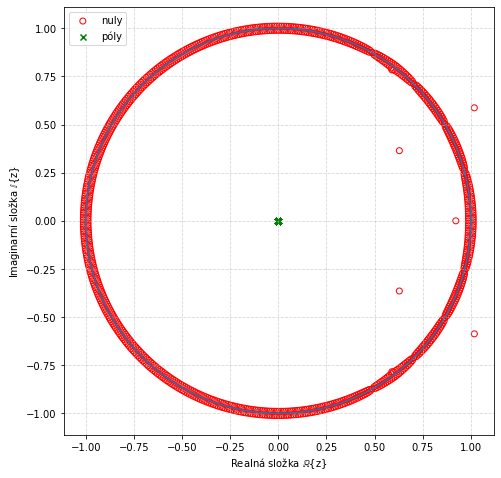

In [508]:
# zjisteni nul a polu
# tez mozno pouzit z = np.roots(b)
z, p, _ = tf2zpk(b, a)

plt.figure(figsize=(7, 7))
# jednotkova kruznice
ang = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none',
            edgecolors='r', label='nuly')
plt.scatter(np.real(p), np.imag(p), marker='x', color='g',
            label='póly')

# pojmenovani os
plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
plt.gca().set_aspect('equal')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

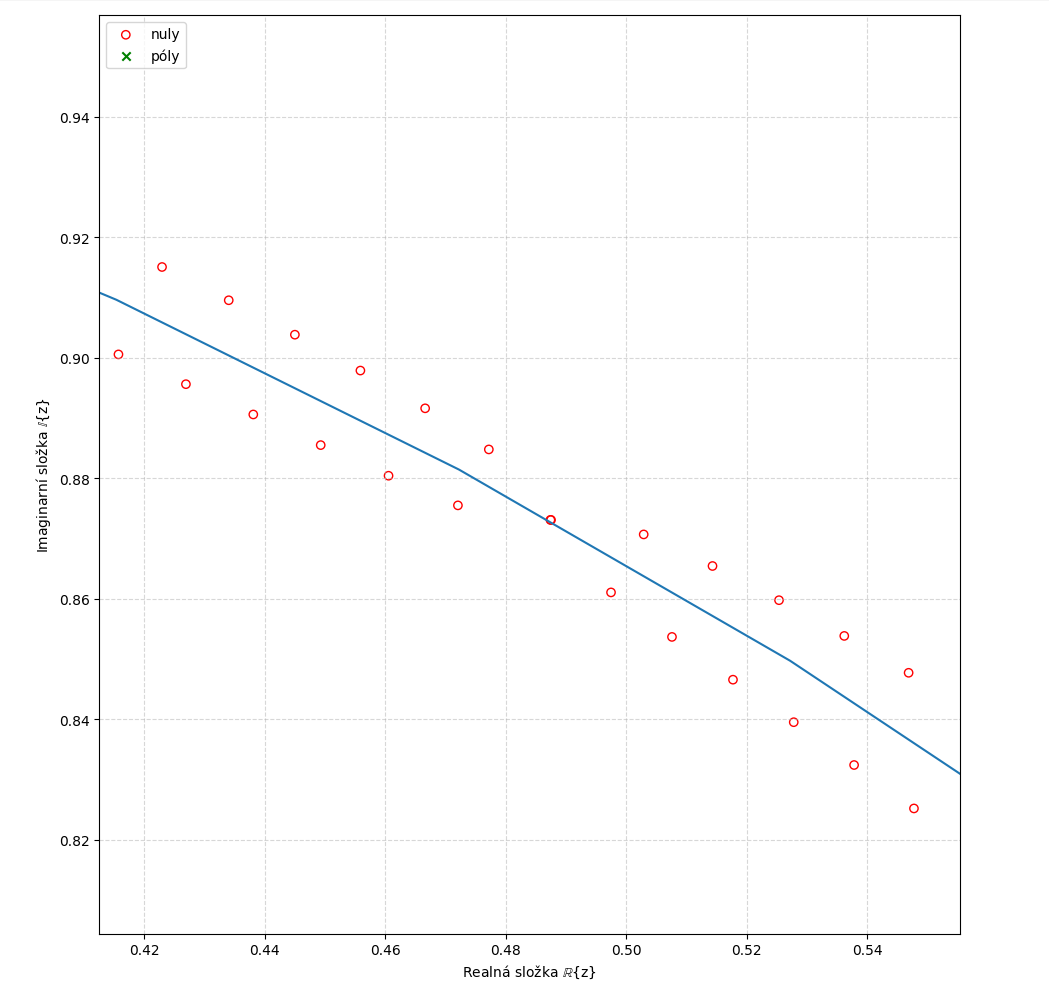

### Frekvenční charakteristika a filtrace
Viz. [Frekvenční charakteristika](#frequency_response) a [Filtrace](#filtration)

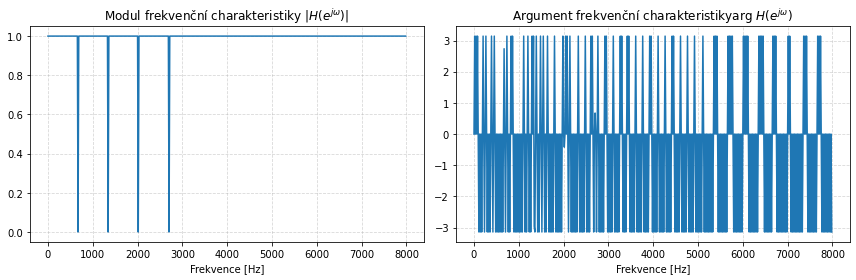

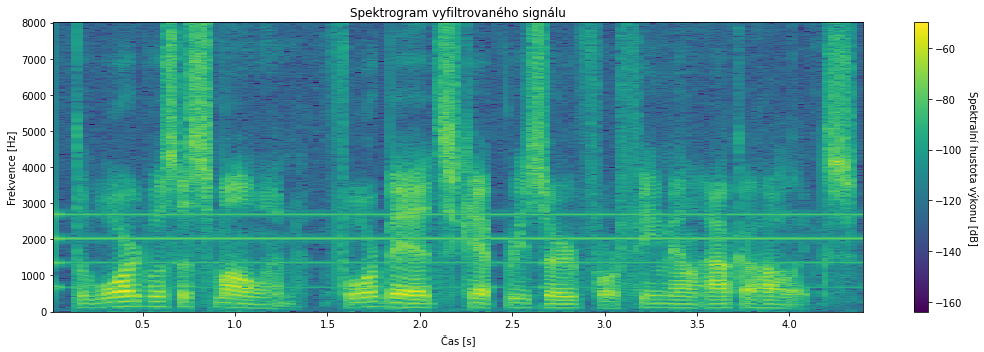

In [509]:
# frekvencni charakteristika
w, H = freqz(b, a)

# vykresleni grafu
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(w / 2 / np.pi * fs, np.abs(H))
ax[0].set_xlabel('Frekvence [Hz]')
ax[0].set_title('Modul frekvenční charakteristiky $|H(e^{j\omega})|$')

ax[1].plot(w / 2 / np.pi * fs, np.angle(H))
ax[1].set_xlabel('Frekvence [Hz]')
ax[1].set_title('Argument frekvenční charakteristiky' \
                '$\mathrm{arg}\ H(e^{j\omega})$')

for ax1 in ax:
    ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()

# provedeni filtrace
filtered_spec = lfilter(b, a, data)

# vykresleni spektrogramu
f, t, sfgr = spectrogram(filtered_spec, fs, nperseg=1024, noverlap=512)
sfgr_log = 10 * np.log10(sfgr+1e-20)

plt.figure(figsize=(15, 5))
plt.pcolormesh(t, f, sfgr_log)

# pojemovani os
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

# normalizace signalu
filtered_max = filtered_spec.max()
filtered_spec = filtered_spec / filtered_max

# zesileni signalu
filtered_spec = np.iinfo(np.int16).max * filtered_spec

plt.tight_layout()

# vytvoreni vyfiltrovaneho souboru
wavfile.write(get_audio_path(f'clean_spec.wav'), fs, filtered_spec.astype(np.int16))

### Výsledek filtrace
Oproti minulé filtrace vypada tento signál lépe, nicméně se mi nepodařilo úspěšně odstranit rušivé frekvence, nýbrž jen utlumit. Měl jsem větší úspěch, když jsem utlumil 5 za sebou jdoucích indexů (pro index rušivé frekvence 43 jsem tlumil - nastavil frekvenční charakteristiku na 0 - na indexech 41 až 45). Nicméně to by měla vyřešit třetí filtrace.

### Návrh 4 pásmových zádrží
Poslední filtr se zkládá ze 4 pásmových zádrží. Pro vygenerování zádrží využijeme funkce `scipy.signal.buttord` a `scipy.signal.butter`. 

In [510]:
from scipy.signal import buttord, butter

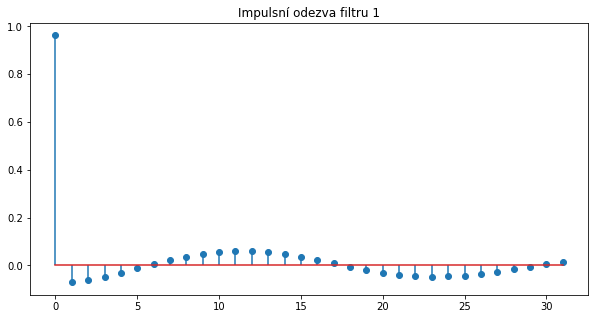

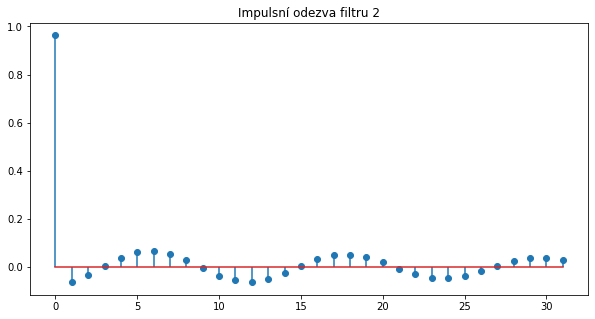

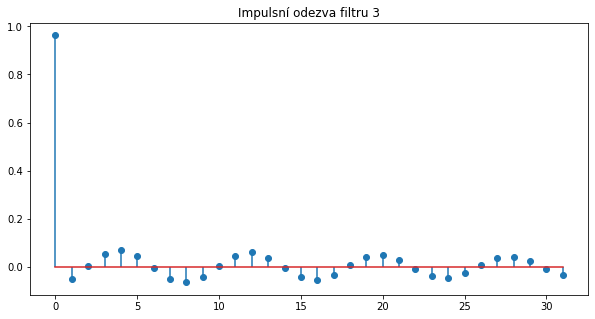

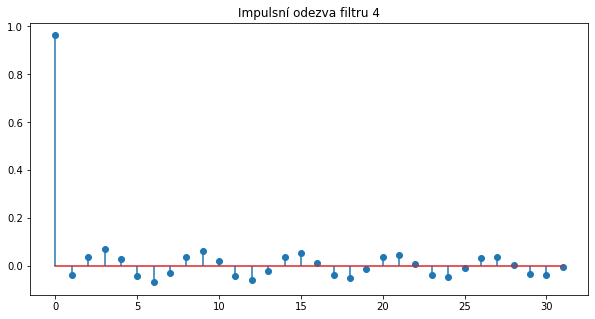

In [511]:
# seznam koeficientu jednotlivych filtru
b_a = []

# Nyquistova frekvence
nyq = fs / 2

# generovani pasmovych zadrzi
for i in range(len(cos_freq)):
    # propustne pasmo
    wp = np.array([cos_freq[i] - 30, cos_freq[i] + 30])
    # zaverne pasmo
    ws = np.array([wp[0] - 50, wp[1] + 50])
    # vypocet koeficientu
    N, Wn = buttord(wp / nyq, ws / nyq, 3, 40)
    b, a = butter(N, Wn, 'bandstop')

    # impulsni odezva filtru
    nof_imp = 32
    imp = [1, *np.zeros(nof_imp-1)]
    h = lfilter(b, a, imp)
    
    # vykresleni grafu
    plt.figure(figsize=(10, 5))
    plt.stem(np.arange(len(h)), h)
    plt.gca().set_title('Impulsní odezva filtru %d' %(i+1))
    b_a.append((b, a))

In [512]:
# vypis koeficientu
for i in range(len(cos_freq)):
    if i != 0:
        print('===========================')
    print(f"{i+1}. filtr:")
    print(f'b: {b}')
    print(f'a: {a}')

1. filtr:
b: [  0.96257506  -4.69336196  13.96650804 -27.69977749  41.43898429
 -46.86168271  41.43898429 -27.69977749  13.96650804  -4.69336196
   0.96257506]
a: [  1.          -4.83864522  14.2888477  -28.12302547  41.75167503
 -46.85628713  41.11949732 -27.27782779  13.64956398  -4.55217601
   0.92655075]
2. filtr:
b: [  0.96257506  -4.69336196  13.96650804 -27.69977749  41.43898429
 -46.86168271  41.43898429 -27.69977749  13.96650804  -4.69336196
   0.96257506]
a: [  1.          -4.83864522  14.2888477  -28.12302547  41.75167503
 -46.85628713  41.11949732 -27.27782779  13.64956398  -4.55217601
   0.92655075]
3. filtr:
b: [  0.96257506  -4.69336196  13.96650804 -27.69977749  41.43898429
 -46.86168271  41.43898429 -27.69977749  13.96650804  -4.69336196
   0.96257506]
a: [  1.          -4.83864522  14.2888477  -28.12302547  41.75167503
 -46.85628713  41.11949732 -27.27782779  13.64956398  -4.55217601
   0.92655075]
4. filtr:
b: [  0.96257506  -4.69336196  13.96650804 -27.69977749  41.

### Nuly a póly
Vypočítáme si nuly a póly jednotlivých filtrů a výsledné body zobrazíme na jednotlivé kružnici. Opět na to použijeme příkaz `scipy.signal.tf2zpk`.

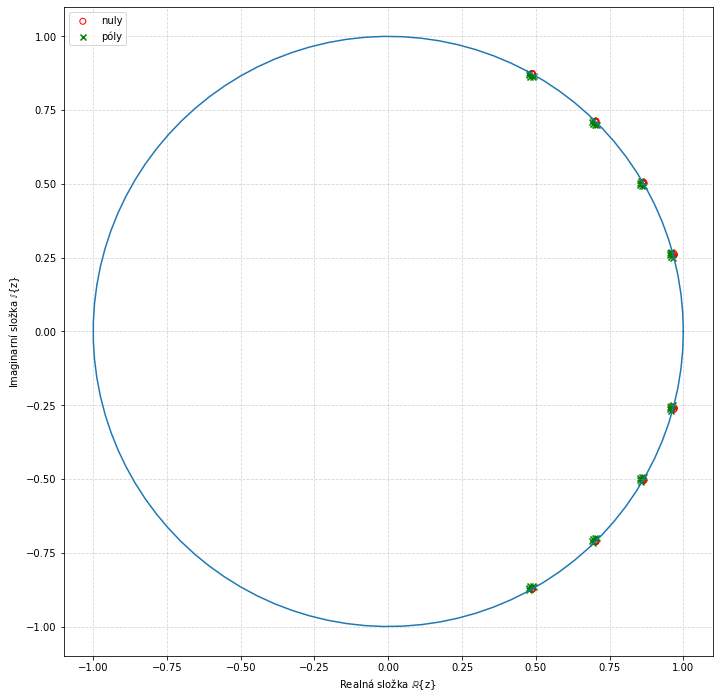

In [513]:
lof_z = []
lof_p = []

# vypocet jednotlivych nul a pol
for b, a in b_a:
    z, p, _ = tf2zpk(b, a)
    lof_z.append(z)
    lof_p.append(p)

# jednotkova kruznice
plt.figure(figsize=(10, 10))
ang = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(lof_z), np.imag(lof_z), marker='o',
            facecolors='none', edgecolors='r', label='nuly')
plt.scatter(np.real(lof_p), np.imag(lof_p), marker='x',
            color='g', label='póly')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')
plt.gca().set_aspect('equal')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='upper left')

plt.tight_layout()

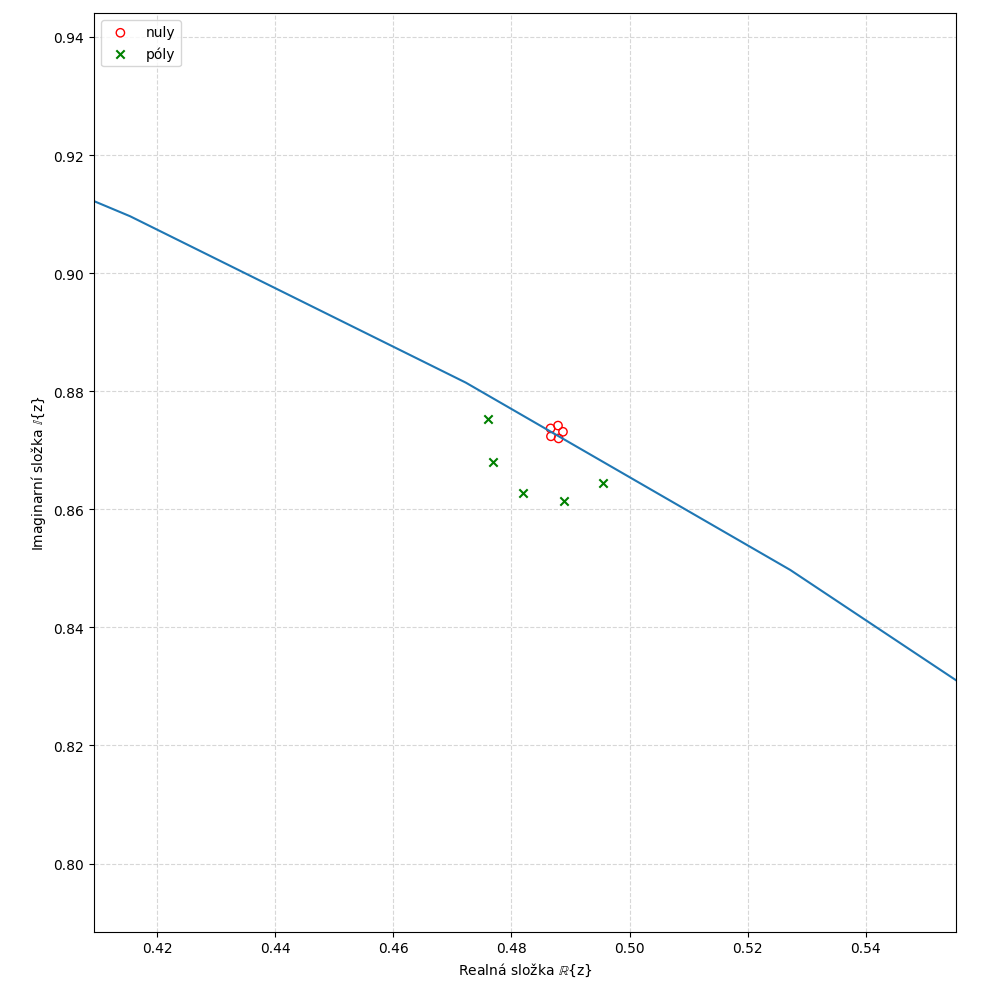

### Frekvenční analýza a filtrace
Viz. [Frekvenční charakteristika](#frequency_response) a [Filtrace](#filtration)

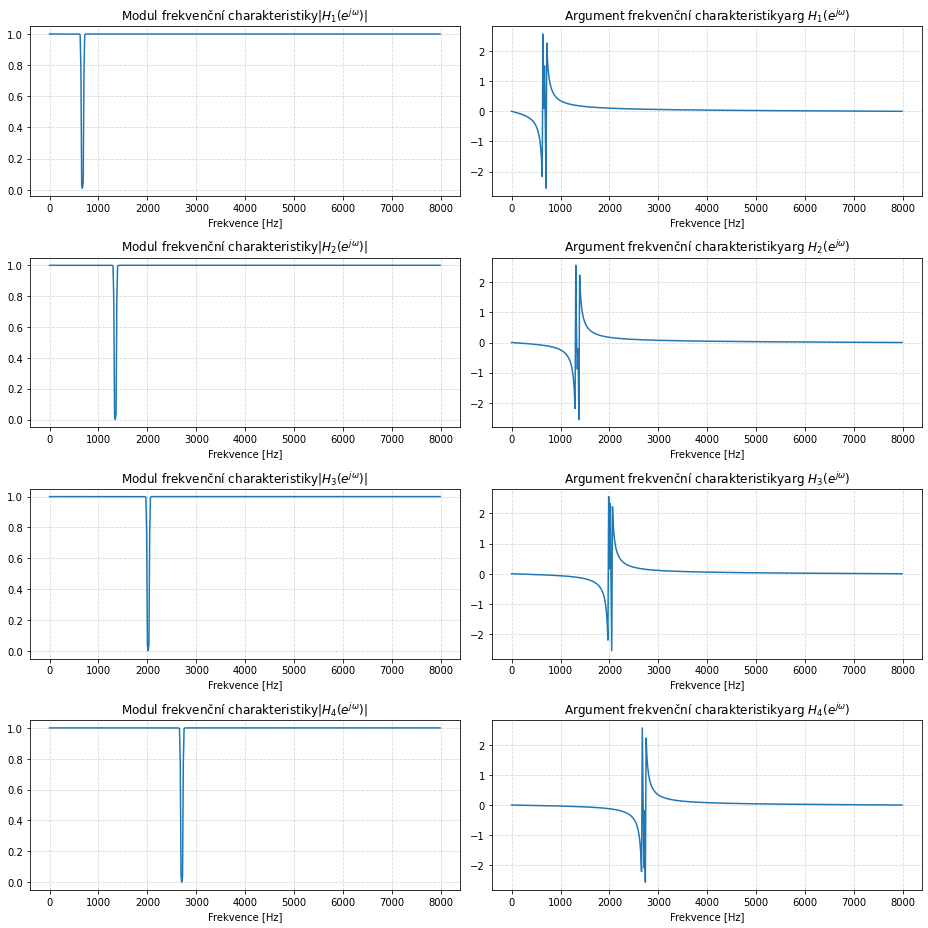

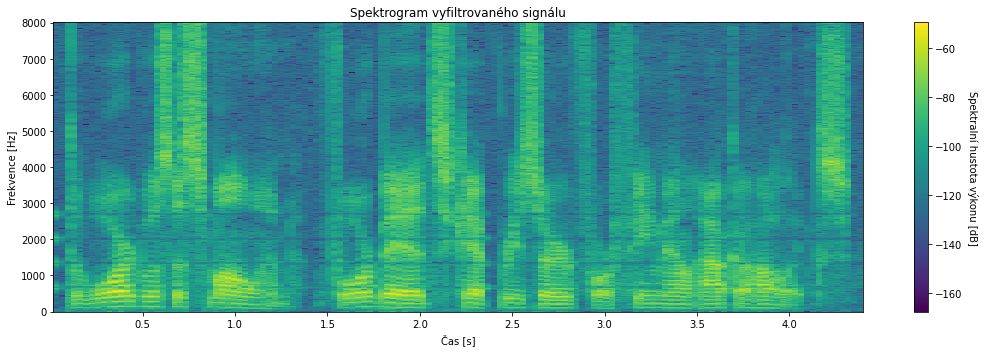

In [514]:
# inicializace grafu
_, ax = plt.subplots(4, 2, figsize=(13, 13))
filtered_bandstop = data

for i in range(len(b_a)):
    b, a = b_a[i]

    # frekvencni charakteristika
    w, H = freqz(b, a)

    # vykresleni jednotlivych pasmovych zadrzi
    ax[i, 0].plot(w / 2 / np.pi * fs, np.abs(H))
    ax[i, 0].set_xlabel('Frekvence [Hz]')
    ax[i, 0].set_title('Modul frekvenční charakteristiky' \
                       '$|H_%d(e^{j\omega})|$' %(i+1))
    ax[i, 0].grid(alpha=0.5, linestyle='--')

    ax[i, 1].plot(w / 2 / np.pi * fs, np.angle(H))
    ax[i, 1].set_xlabel('Frekvence [Hz]')
    ax[i, 1].set_title('Argument frekvenční charakteristiky' \
                         '$\mathrm{arg}\ H_%d(e^{j\omega})$' %(i+1))
    ax[i, 1].grid(alpha=0.5, linestyle='--')
    # provedeni filtrace
    filtered_bandstop = lfilter(b, a, filtered_bandstop)

plt.tight_layout()

# vykresleni spektrogramu
f, t, sfgr = spectrogram(filtered_bandstop, fs, nperseg=1024, noverlap=512)
sfgr_log = 10 * np.log10(sfgr+1e-20)

plt.figure(figsize=(15, 5))
plt.pcolormesh(t, f, sfgr_log)

# pojemovani os
plt.gca().set_title('Spektrogram vyfiltrovaného signálu')
plt.gca().set_xlabel('Čas [s]')
plt.gca().set_ylabel('Frekvence [Hz]')
cbar = plt.colorbar()
cbar.set_label('Spektralní hustota výkonu [dB]', rotation=270, labelpad=15)

# normalizace signalu
filtered_max = filtered_bandstop.max()
filtered_bandstop = filtered_bandstop / filtered_max
filtered_bandstop = np.iinfo(np.int16).max * filtered_bandstop

plt.tight_layout()

# vytvoreni vyfiltrovaneho souboru
wavfile.write(get_audio_path(f'clean_bandstop.wav'), fs, filtered_bandstop.astype(np.int16))

### Výsledek filtrace
Tento filtr byl ze všech tří filtrů nejúčinější. Z výsledného signálu rušivé frekvence kompletně vymizely. Výsledná nahrávka je zcela srozumitelná.

## Pomocné funkce

In [515]:
import os

In [516]:
def get_audio_path(filename: str) -> str:
    """
    Vygeneruje cestu ke zdroji zvuku

    Parameters:

    filename: jmeno souboru
    
    Returs: cesta k souboru
    """
    src_dir = os.path.abspath('')
    parent_dir = os.path.abspath(os.path.join(src_dir, os.pardir))
    return os.path.abspath(os.path.join(parent_dir, 'audio/', filename))

## Zdroje informací
- [Notebook ing. Kateřiny Žmolíkové](https://nbviewer.org/github/zmolikova/ISS_project_study_phase/blob/master/Zvuk_spektra_filtrace.ipynb)
- [Matplotlib dokumentace](https://matplotlib.org/stable/api/pyplot_summary.html)
- [Numpy dokumentace](https://numpy.org/doc/stable/reference/)
- [Scipy dokumentace](https://docs.scipy.org/doc/scipy/reference/tutorial/index.html)
- [Studijní opora předmětu ISS](https://www.fit.vutbr.cz/study/courses/ISS/public/opora/iss.pdf)

